In [1]:
# !pip install gekko
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import json
from lib import *

In [2]:
%load_ext autoreload
%autoreload 2

## Experiment 1

$$
\textbf{MINLP}: 
\min\limits_{\textbf{x}, \textbf{u}, \textbf{i}}
F(\textbf{x}, \textbf{u}, \textbf{i}), \quad
\text{such that} \;\;
\left\{ \begin{array}{l}
x(0) = x_0 \\
\dot{x}(k) = f(x(k), u(k), i(k)) \\
\textbf{i} \in P \cap \mathbb{Z}^{N} \\
\end{array} \right.
$$

* variables
    * $\textbf{x} = (x(0), x(1), \dots, x(N))$
    * $\textbf{u} = (u(0), u(1), \dots, u(N-1))$
    * $\textbf{i} = (i(0), i(1), \dots, i(N-1))$

* objective function $
F(\textbf{x}, \textbf{u}, \textbf{i}) = 
\sum\limits^{N}_{k=0} F(x(k), u(k), i(k))
$, where
$
F(x, u, i) = 
\frac{1}{2} \| F_1(x, u, i) \|^2_2
$ and 
$
F_1(x, u, i) = 
(x - x_{ref}, 0, 0)
$
* equality function $
f(x, u, i) = x - i
$
* polygon $
P = 
\left\{ \textbf{i} \in [0, 1]^N \ \bigg| \ \begin{align} 
    & i(k) \geq i(k-1) - i(k-2) \\
    & i(k) \geq i(k-1) - i(k-3) 
\end{align} \right\}
$
* parameters $
N = 30, \ x_0 = 0.8, \ x_{ref} = 0.7$

Define parameters and functions:

In [3]:
N = 30
time_step = 0.05
x_0 = 0.8
x_ref = 0.7

In [4]:
# Differential equation:
def f(x, u, i):
    return x - i

# Path inequality constraints:
def h(x, u, i):
    return x - x

# Objective function
def F1(x, u, i):
    return x - x_ref

def F(x, u, i):
    return 0.5 * (F1(x, u, i) ** 2)

### Solution 1 : GEKKO

Exact integer solution from GEKKO - **branch-and-bound method**.

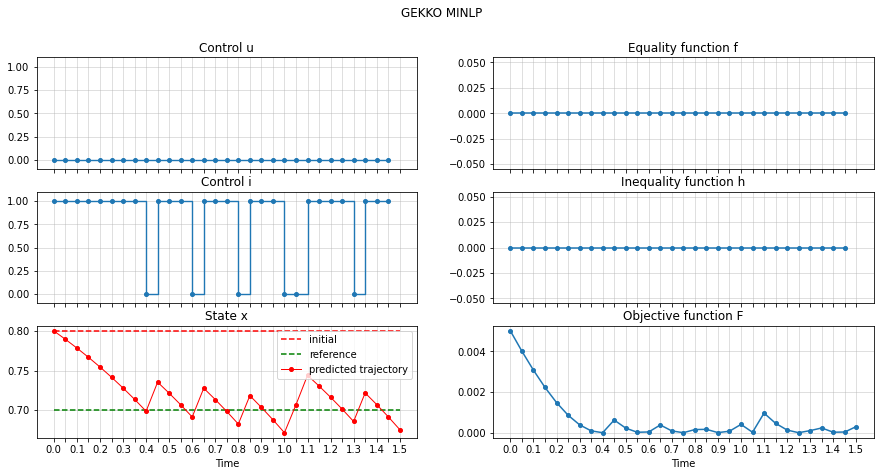

Objective value: 0.0166111607


In [5]:
options = [
    'minlp_maximum_iterations 5000', # 10.000
    'minlp_max_iter_with_int_sol 5000', # 500
    'minlp_as_nlp 0', # 1
    'minlp_branch_method 2', # 3
    'minlp_gap_tol 5e-5', # 0.01
    'minlp_integer_tol 5e-5', # 0.01
]

history_minlp = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, 
                                    options, integer=True, name='GEKKO MINLP')
show_results(history_minlp)

### Solution 2 : Gauss-Newton algorithm

**S1**: solve it without integrality constraint $\textbf{i} \in \mathbb{Z}^{n_i}$.

$$
\textbf{NLP}:
(\textbf{x}^*, \textbf{u}^*, \textbf{i}^*) = 
\text{arg} \min\limits_{\textbf{x}, \textbf{u}, \textbf{i}}
F(\textbf{x}, \textbf{u}, \textbf{i}), \quad
\text{such that} \;\;
\left\{ \begin{array}{l}
x(0) = x_0 \\
\dot{x}(k) = f(x(k), u(k), i(k)) \\
\textbf{i} \in P \\
\end{array} \right.
$$

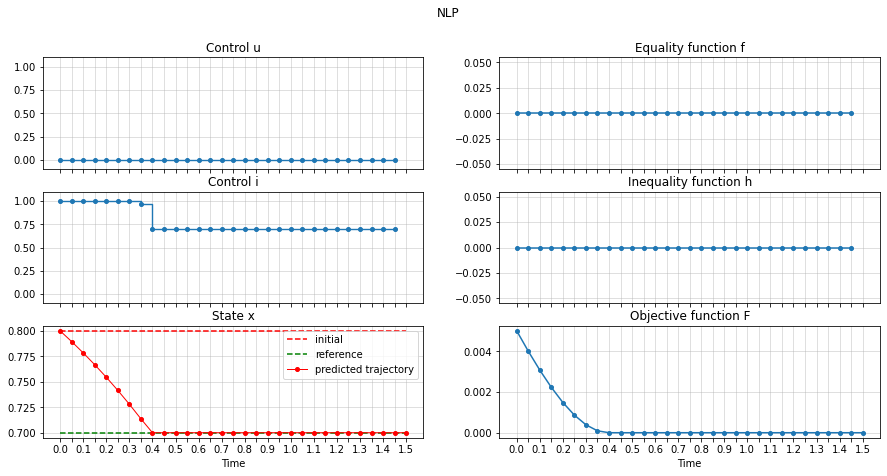

Objective value: 0.0121292875


In [6]:
history_nlp = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, options, integer=False, name='NLP')
show_results(history_nlp)

**S2**: approximate our continuous solution $\textbf{i}^*$ by an integer $\textbf{i}^{**}$ with the **dist** function.


$$
\textbf{DIST}: 
(\textbf{x}^{**}, \textbf{u}^{**}, \textbf{i}^{**}) = 
\text{arg} \min\limits_{\textbf{x}, \textbf{u}, \textbf{i}}
F_{GN}(\textbf{x}, \textbf{u}, \textbf{i} \mid 
\textbf{x}^*, \textbf{u}^*, \textbf{i}^*)
, \quad
\left\{ \begin{array}{l}
x(0) = x_0 \\
\dot{x}(k) = f_L(x(k), u(k), i(k)) \\
\textbf{i} \in P \cap \mathbb{Z}^{N \cdot n_i}
\end{array} \right.
$$

In [7]:
x_nlp = history_nlp['x']
u_nlp = history_nlp['u']
i_nlp = history_nlp['i']
obj_nlp = history_nlp['obj_value']

f_L  = lambda x, x0: linear(f, x, x0)
h_L  = lambda x, x0: linear(h, x, x0)
F_L  = lambda x, x0: linear(F, x, x0)
F_QP = lambda x, x0: gauss_newton(F, F1, x, x0)
F_GN = lambda x, x0: F_QP(x, x0) #- obj_nlp

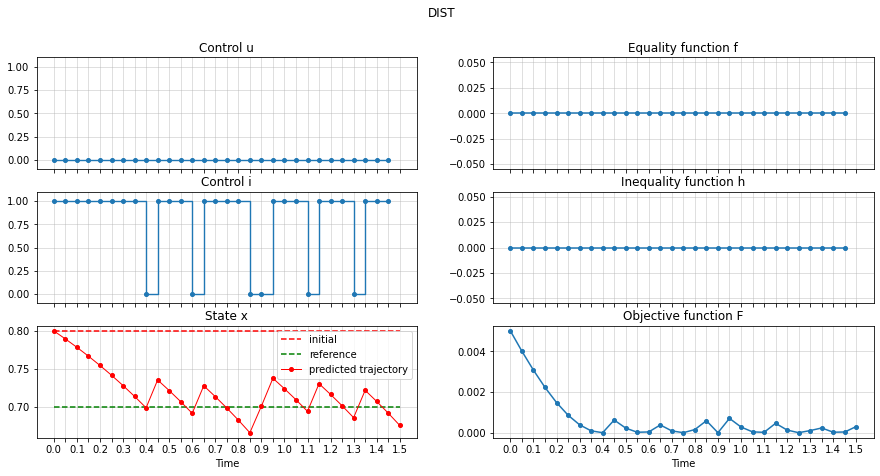

Objective value: 0.0166034246


In [8]:
history_dist = run_optimal_control_dist(x_0, x_ref, x_nlp, u_nlp, i_nlp, N, 
                                        time_step, f_L, h_L, F_GN, options, F, 'DIST')
show_results(history_dist)

**S3**: solve the NLP system with fixed variable $\textbf{i} = \textbf{i}^{**} = y^{**}$:

$$
\textbf{NLP}:
(\textbf{x}^{***}, \textbf{u}^{***}, \textbf{i}^{**}) = 
\arg\min\limits_{\textbf{x, u}}{F(\textbf{x}, \textbf{u}, \textbf{i}^{**})}
, \quad
\left\{ \begin{array}{l}
x(0) = x_0 \\
x(k+1) = f(x(k), u(k), i^{**}(k))
\end{array} \right.
$$

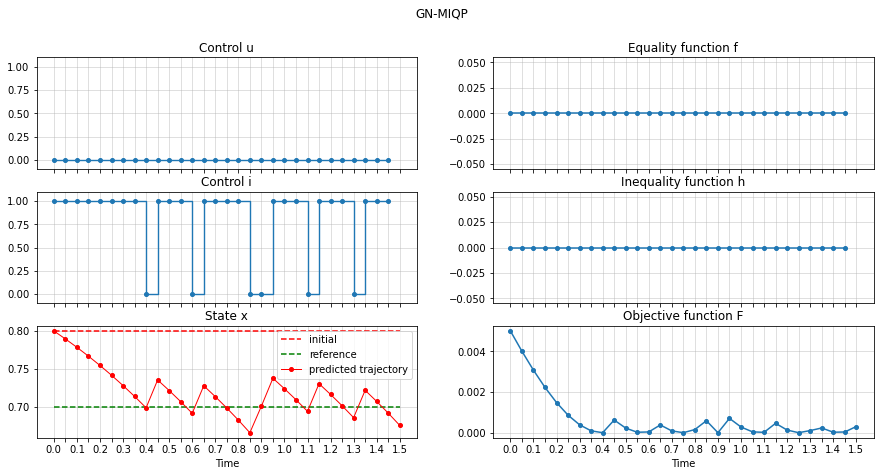

Objective value: 0.0166046715


In [9]:
history_gn = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, options, integer=True, 
                                   const=True, const_i=history_dist['i'], name='GN-MIQP')
show_results(history_gn)

### Comparing

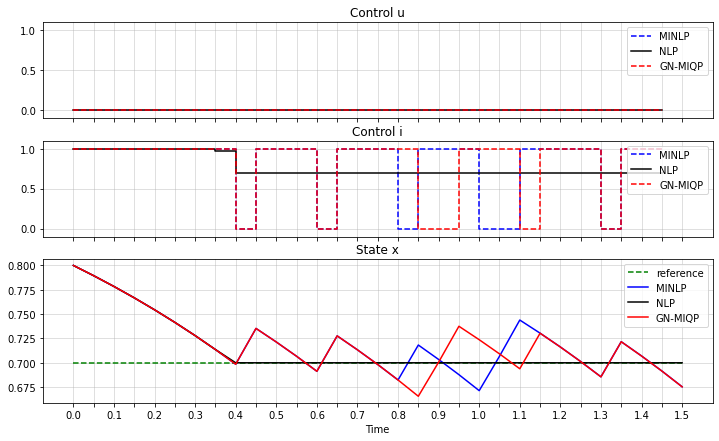

Objective value
---------------------
GEKKO MINLP : 0.01661
        NLP : 0.01213
    GN-MIQP : 0.01660
---------------------
GN-MIQP is equal to GEKKO MINLP


In [10]:
compare_results(history_minlp, history_nlp, history_gn)

## Experiment 2

Here we replace our equality fuction by something nonlinear: $f(x, u, i) = x^3 - i$. Now our problem coincedes with the article problem.

In [11]:
def f(x, u, i):
    return x ** 3 - i

### Solution 1: GEKKO

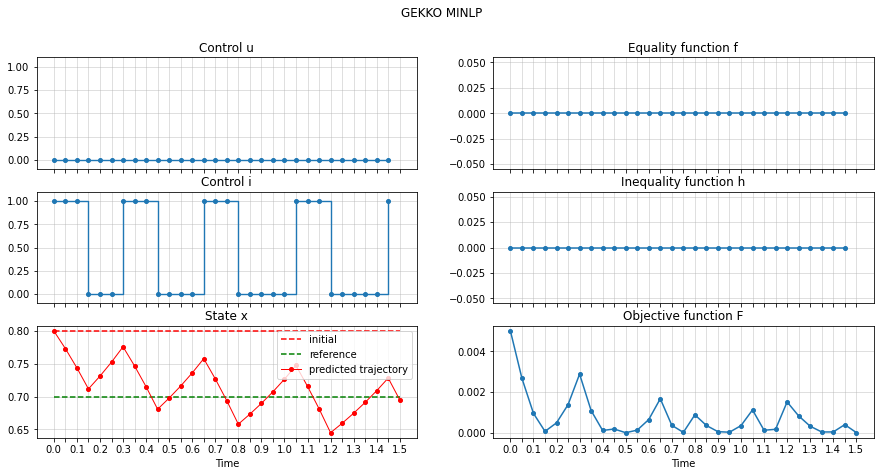

Objective value: 0.0189190014


In [12]:
history_minlp = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, 
                                    options, integer=True, name='GEKKO MINLP')
show_results(history_minlp)

Objective value from the article: 0.0207

### Solution 2: Gauss-Newton

#### S1: NLP

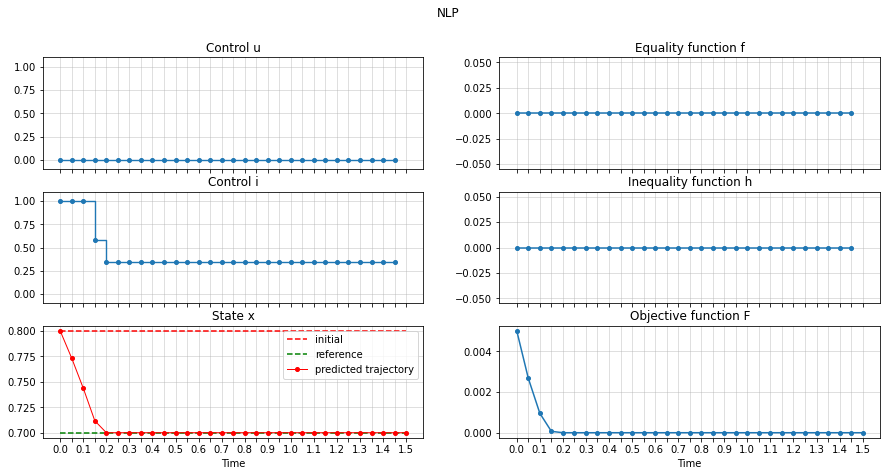

Objective value: 0.0036938657


In [13]:
history_nlp = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, options, integer=False, name='NLP')
show_results(history_nlp)

Objective value from the article: 0.00897

I guess these values differ because __regularly__ our GEKKO score and the article score ignore the first difference $F(x(0), u(0), i(0))$ and, therefore, coincide (the previous values 0.0189 and 0.0207 are practically the same), but __here__ (and only here) the article scores, for some reason, includes the first difference:

In [14]:
history_nlp['obj_value'] + F(history_nlp['x'][0], history_nlp['u'][0], history_nlp['i'][0])

0.00869386566170001

That seems to be true.

#### S2: Gauss-Newton distance

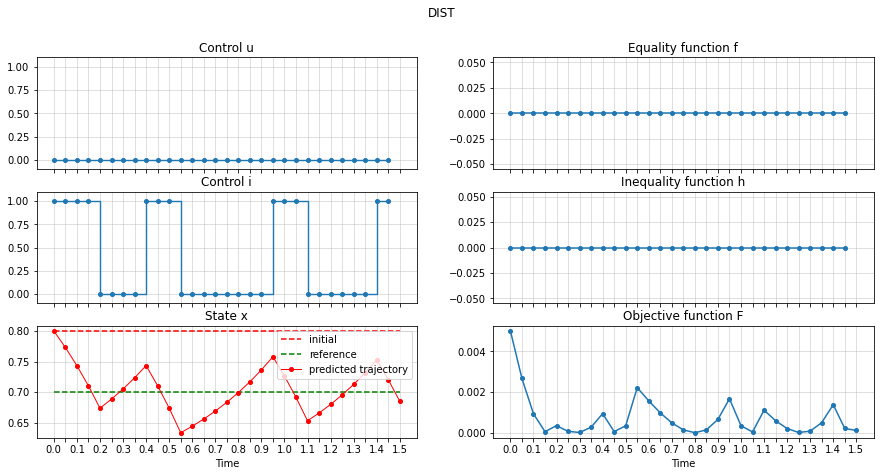

Objective value: -0.0927227032


In [15]:
x_nlp = history_nlp['x']
u_nlp = history_nlp['u']
i_nlp = history_nlp['i']
obj_nlp = history_nlp['obj_value']

f_L  = lambda x, x0: linear(f, x, x0)
h_L  = lambda x, x0: linear(h, x, x0)
F_L  = lambda x, x0: linear(F, x, x0)
F_QP = lambda x, x0: gauss_newton(F, F1, x, x0)
F_GN = lambda x, x0: F_QP(x, x0) - obj_nlp

history_dist = run_optimal_control_dist(x_0, x_ref, x_nlp, u_nlp, i_nlp, N, 
                                        time_step, f_L, h_L, F_GN, options, F, 'DIST')
show_results(history_dist)

#### S3

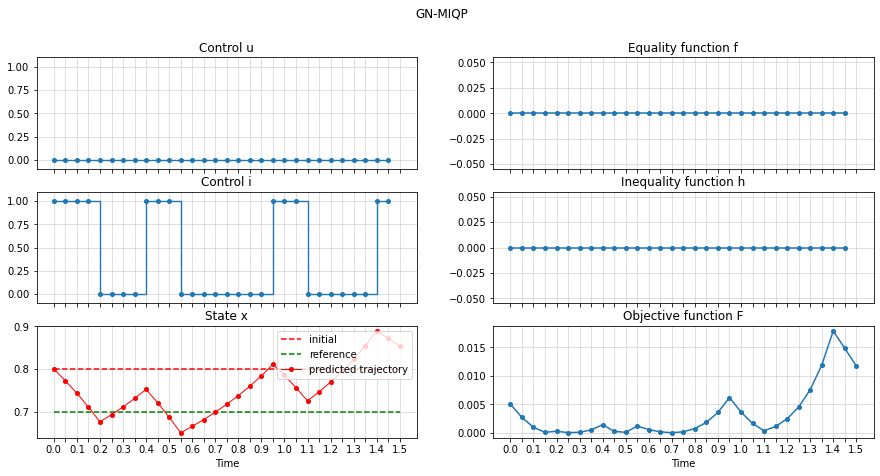

Objective value: 0.0979080167


In [16]:
history_gn = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, options, integer=True, 
                                   const=True, const_i=history_dist['i'], name='GN-MIQP')
show_results(history_gn)

Why does **S3** objective value is so big while **S2** one is pretty small? Let's take a look at the difference between **S3** state path and **S2** state path:

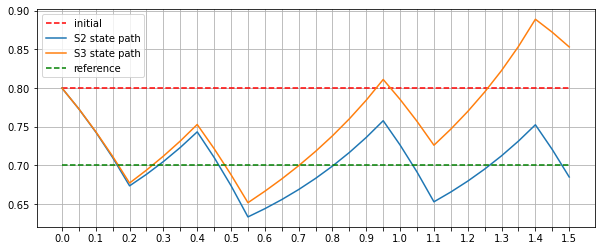

In [18]:
plt.figure(figsize=(10, 4))
ax = plt.axes()
x = history_dist['time']
ax.hlines(x_0, x[0], x[-1], linestyle='--', color='r', label='initial')
ax.plot(x, history_dist['x'], label='S2 state path')
ax.plot(x, history_gn['x'], label='S3 state path')
ax.hlines(x_ref, x[0], x[-1], linestyle='--', color='g', label='reference')
ax.set_xticks(x)
ax.set_xticklabels(['' if i % 2 else t for i, t in enumerate(x)])
ax.grid()
ax.legend(loc=0)
plt.show()

The only reason this happens is the difference in the exact value of $f$ and its linearization. Since this is the only place where the **S2** and **S3** algorithm differ.

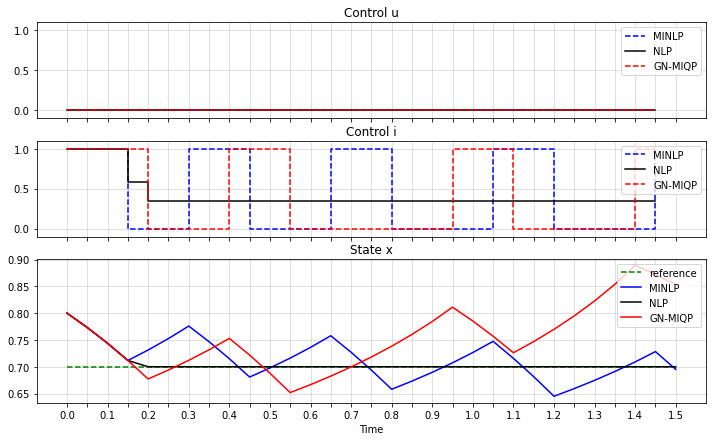

Objective value
---------------------
GEKKO MINLP : 0.01892
        NLP : 0.00369
    GN-MIQP : 0.09791
---------------------
GN-MIQP is worse than GEKKO MINLP


In [19]:
compare_results(history_minlp, history_nlp, history_gn)

Let's check the Gauss-Newton solution from the article.

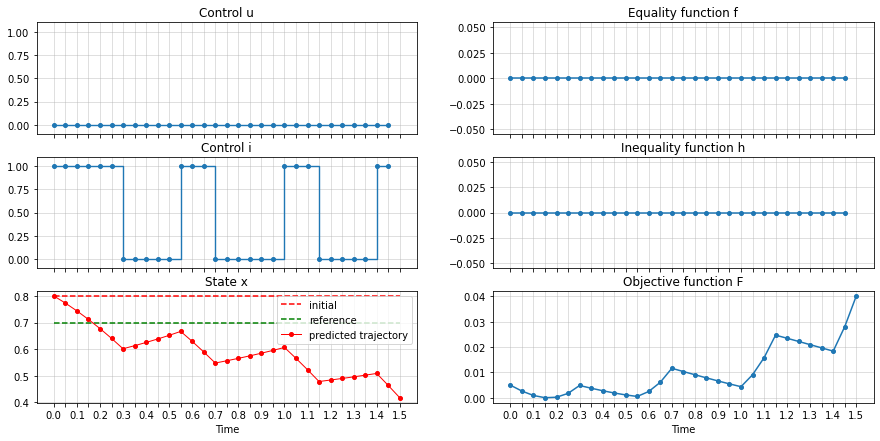

Objective value: 0.3074584276


In [20]:
const_i = [0] + [1] * 6 + [0] * 5 + [1] * 3 + [0] * 6 + [1] * 3 + [0] * 5 + [1] * 2
assert len(const_i) == N+1, len(const_i)
history_gn_article = run_optimal_control(x_0, x_ref, N, time_step, f, h, F, options, 
                                           integer=True, const=True, const_i=const_i)
show_results(history_gn_article)

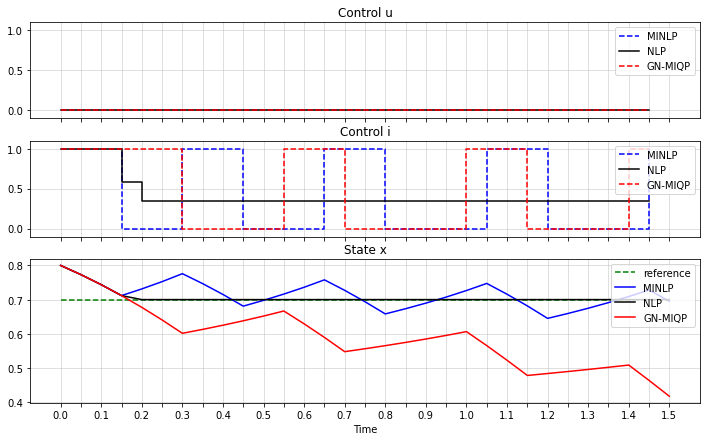

Objective value
---------------------
GEKKO MINLP : 0.01892
        NLP : 0.00369
    GN-MIQP : 0.30746
---------------------
GN-MIQP is worse than GEKKO MINLP


In [21]:
compare_results(history_minlp, history_nlp, history_gn_article)

As we can see, the result isn't pretty good and, actually, it doesn't match the article's results...